*Page and Latex Commands*
$\renewcommand{\C}{\mathbb{C}}
\renewcommand{\R}{\mathbb{R}}
\renewcommand{\Z}{\mathbb{Z}}
\renewcommand{\N}{\mathbb{N}}
\renewcommand{\Q}{\mathbb{Q}}
\renewcommand{\mP}{\mathcal{P}}
\renewcommand{\bp}{\begin{pmatrix}}
\renewcommand{\ep}{\end{pmatrix}}
$

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('../')
from lib.design import *

plt.style.use('classic')
#sns.set()

# Kantorovich-Rubenstein OT with Linear Solvers

**Problem Statement**

Provided initial mass distribution $\rho$ and final mass distribution $\sigma$ over a compact metric space $X$, along with the gradient of the cost function for each point in the space $\nabla c : x\in X \rightarrow \R^+$ find the function which minimizes the following integral equation

$$\begin{align*} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) \\
                \text{s.t.}\quad & |\nabla \phi(x)|\leq |\nabla c(x)|,\quad \forall x\in X \end{align*}$$


**Design Method**

* Solve $\nabla u$

$$\begin{align*}
-\nabla \cdot (A^* \nabla u) &= \sigma - \rho\\
\frac{\partial u}{\partial n} = 0,&\quad \text{ on } \partial \Omega \end{align*}$$

* Solve $\nabla p$
$$\begin{align*}
-\nabla \cdot (A^* \nabla p) &= -2(u-u_0)\\
p = 0,&\quad \text{ on } \partial \Omega \end{align*}$$

* Update $\theta$
$$\begin{align*}
\theta_{k+1} = \max \bigg( 0,\min \bigg(1,\theta_k-t_k\bigg(\ell_k+\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\bigg) \bigg)\bigg)\end{align*}$$

* Update $\phi$
$$\begin{align*}
\phi_{k+1} = \phi_k-t_k\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\end{align*}$$

*Specifics*

$$\begin{align*}
\lambda_- = \bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-1},&\quad \lambda_+ = \alpha\theta+\beta(1-\theta)\\
A^* = \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}&
\begin{pmatrix} \lambda_+ & 0\\ 0 & \lambda_-\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\
&=\begin{pmatrix}
\lambda_+\cos^2(\phi)+\lambda_-\sin^2(\phi) & (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi)
\\ (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi) & \lambda_+\sin^2(\phi)+\lambda_-\cos^2(\phi)
\end{pmatrix}\end{align*}$$

Differentation

$$\begin{align*}
\frac{\partial\lambda_-}{\partial\theta} &= -\bigg(\frac{1}{\alpha} - \frac{1}{\beta}\bigg)\bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-2}\\
\frac{\partial\lambda_+}{\partial\theta} &= \alpha-\beta\\
\frac{\partial A}{\partial\theta} &= \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}
\begin{pmatrix} \frac{\partial\lambda_+}{\partial\theta} & 0\\ 0 & \frac{\partial\lambda_-}{\partial\theta}\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\
\frac{\partial A}{\partial\phi} &= \begin{pmatrix} (-\lambda_++\lambda_-)(2\cos(\phi)\sin(\phi)) & (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi))
\\ (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi)) & (\lambda_+-\lambda_-)(2\cos(\phi)\sin(\phi)) \end{pmatrix}\end{align*}$$


## Examples

**Split Plates**

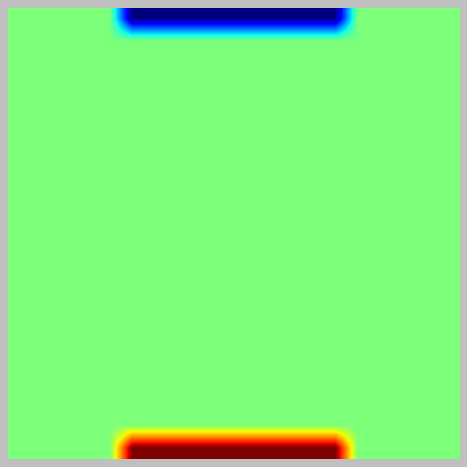

In [2]:
#GRID
n,m=20,20
y=np.linspace(0,1,n)
x=np.linspace(0,1,m)

# Initial Distribution
rho = np.zeros((n,m))
rho[-1,n//4:3*n//4] = np.ones(n//2)

# Final Distribution
sigma = np.zeros((n,m))
sigma[0,n//4:3*n//4] = np.ones(n//2)


f = (sigma-rho).flatten()
plt.figure(tight_layout=True)
plt.imshow((sigma-rho)[::-1])
plt.axis('off')
plt.savefig('../out/example1_setup.pdf')

In [3]:
options={'lv':10,'alpha':.5,'beta':1}
prob = design2D(x,y,f,options)
prob.iterate(100)

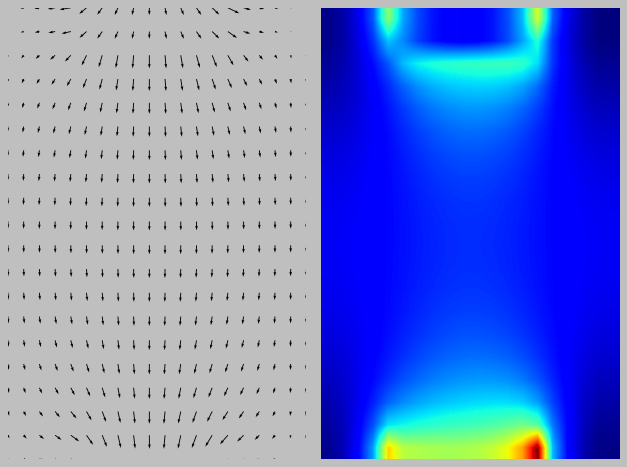

In [4]:
plt.figure(tight_layout=True)
plt.subplot(121)
plt.quiver(prob.xx,prob.yy,prob.ADu.T[0],prob.ADu.T[1])
plt.axis('off')
plt.subplot(122)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1],vmin=0,vmax=1,aspect='auto')
plt.axis('off')
plt.savefig('../out/example1_dispersed.pdf')

In [5]:
options={'lv':1,'alpha':1e-3,'beta':1}
prob = design2D(x,y,f,options)
prob.iterate(100)

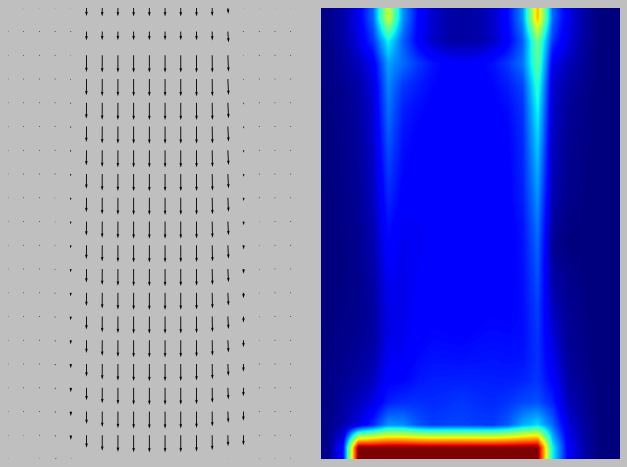

In [6]:
plt.figure(tight_layout=True)
plt.subplot(121)
plt.quiver(prob.xx,prob.yy,prob.ADu.T[0],prob.ADu.T[1])
plt.axis('off')
plt.subplot(122)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1],vmin=0,vmax=1,aspect='auto')
plt.axis('off')
plt.savefig('../out/example1_constrained.pdf')

**Boundary Quadrants**

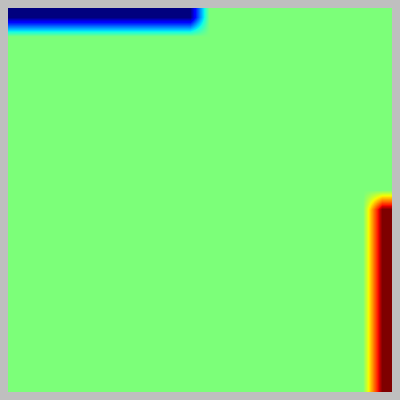

In [7]:
#GRID
n,m=20,20
y=np.linspace(0,1,n)
x=np.linspace(0,1,m)

# Initial Distribution
rho = np.zeros((n,m))
rho[-1,:n//2] = np.ones(n//2)

# Final Distribution
sigma = np.zeros((n,m))
sigma[:n//2,-1] = np.ones(n//2)


f = (sigma-rho).flatten()

plt.imshow((sigma-rho)[::-1])
plt.axis('off')
plt.savefig('../out/example2_setup.pdf')

In [8]:
options={'lv':1,'alpha':1e-2,'beta':1e2}
prob = design2D(x,y,f,options)
prob.iterate(20)

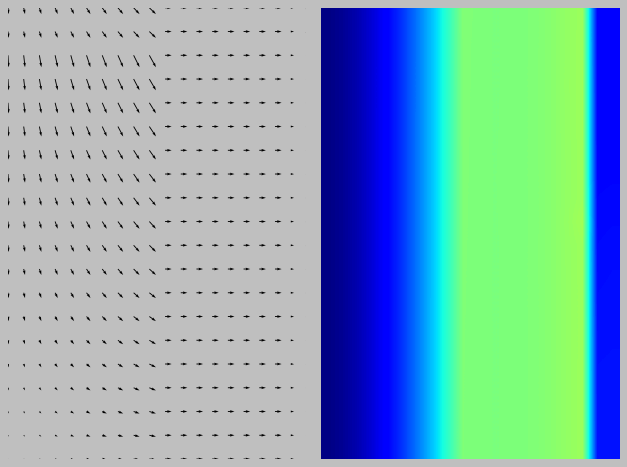

In [9]:
plt.figure(tight_layout=True)
plt.subplot(121)
plt.quiver(prob.xx,prob.yy,prob.ADu.T[0],prob.ADu.T[1])
plt.axis('off')
plt.subplot(122)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1],vmin=0,vmax=1,aspect='auto')
plt.axis('off')
plt.savefig('../out/example2_constrained.pdf')

**Quadrants With Larger Alpha and Lagrange Multiplier**

In [10]:
options={'lv':5,'alpha':.5,'beta':1}
prob = design2D(x,y,f,options)
prob.iterate(200)

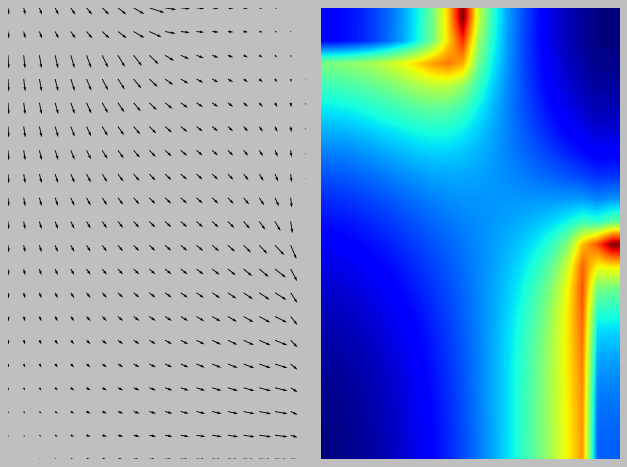

In [11]:
plt.figure(tight_layout=True)
plt.subplot(121)
plt.quiver(prob.xx,prob.yy,prob.ADu.T[0],prob.ADu.T[1])
plt.axis('off')
plt.subplot(122)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1],vmin=0,vmax=1,aspect='auto')
plt.axis('off')
plt.savefig('../out/example1_dispersed.pdf')

**Split Plates**

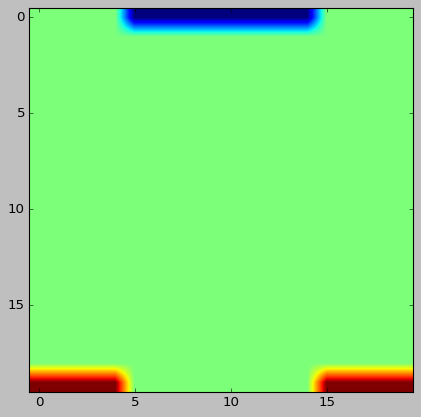

In [12]:
#GRID
n,m=20,20
y=np.linspace(0,1,n)
x=np.linspace(0,1,m)

# Initial Distribution
rho = np.zeros((n,m))
rho[-1,n//4:3*n//4] = np.ones(n//2)

# Final Distribution
sigma = np.zeros((n,m))
sigma[0,:n//4] = np.ones(n//4)
sigma[0,3*n//4:] = np.ones(n//4)

f = (sigma-rho).flatten()

plt.imshow((sigma-rho)[::-1])

In [13]:
options={'lv':1,'alpha':.01,'beta':1}
prob = design2D(x,y,f,options)
prob.iterate(30)

(-0.5, 19.5, 19.5, -0.5)

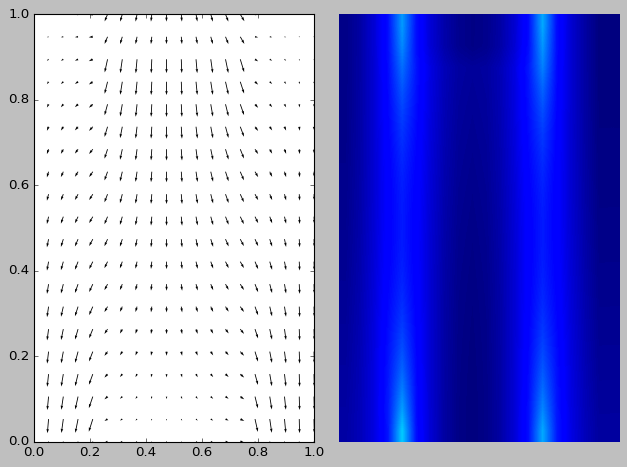

In [14]:
plt.figure(tight_layout=True)
plt.subplot(121)
plt.quiver(prob.xx,prob.yy,prob.ADu.T[0],prob.ADu.T[1])
plt.subplot(122)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1],vmin=0,vmax=1,aspect='auto')
plt.axis('off')

**Split Plates With Larger Alpha**

Notice the smoothness of the vector feild in comparison to the smaller values of alpha.

In [15]:
options={'lv':1,'alpha':.1,'beta':1}
prob = design2D(x,y,f,options)
prob.iterate(50)

(-0.5, 19.5, 19.5, -0.5)

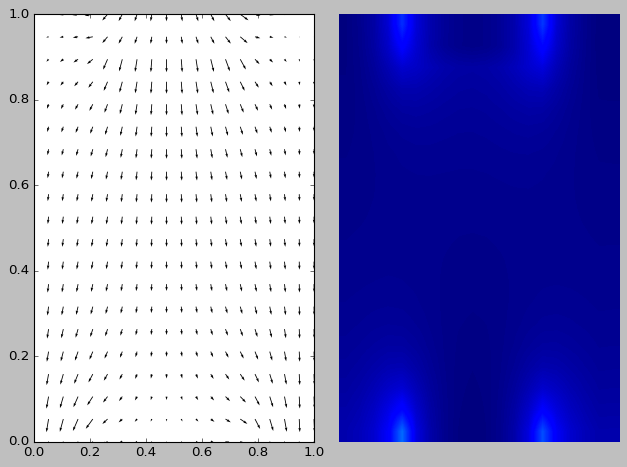

In [16]:
plt.figure(tight_layout=True)
plt.subplot(121)
plt.quiver(prob.xx,prob.yy,prob.ADu.T[0],prob.ADu.T[1])
plt.subplot(122)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1],vmin=0,vmax=1,aspect='auto')
plt.axis('off')